# Term Deposit Subscription Prediction

**Objective:** Predict whether a client will subscribe to a term deposit based on bank marketing campaign data.
We will use EDA, feature engineering, and machine learning techniques to build a predictive model and deploy it using Streamlit.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

### Load Dataset
Load the main dataset for our analysis.

In [4]:
# Load the dataset
df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Data Overview
Explore structure, missing values, and data types.

In [6]:
df.info()
df.describe()
df['y'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

### Exploratory Data Analysis (Extended)
Visualize class distribution, categorical relationships, and feature correlations.

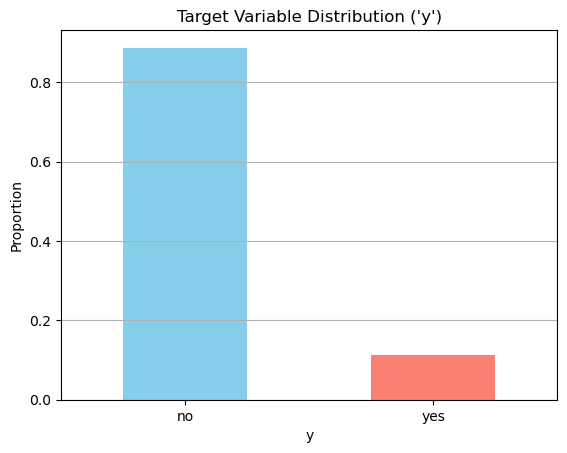

In [8]:
# Plot class distribution
df['y'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Target Variable Distribution ('y')")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [9]:
# Drop 'duration' column to avoid data leakage
df = df.drop(columns='duration')

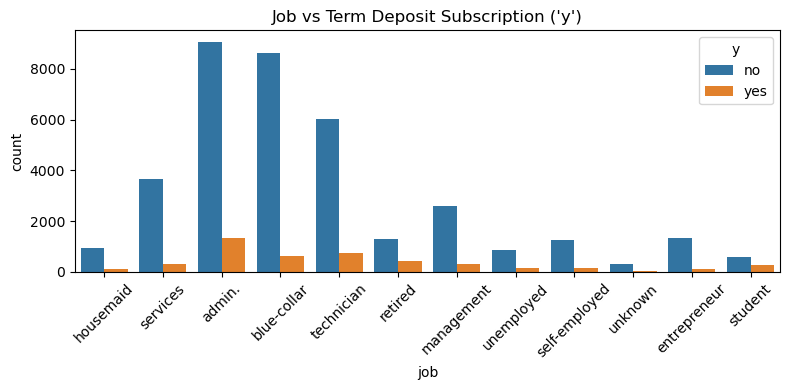

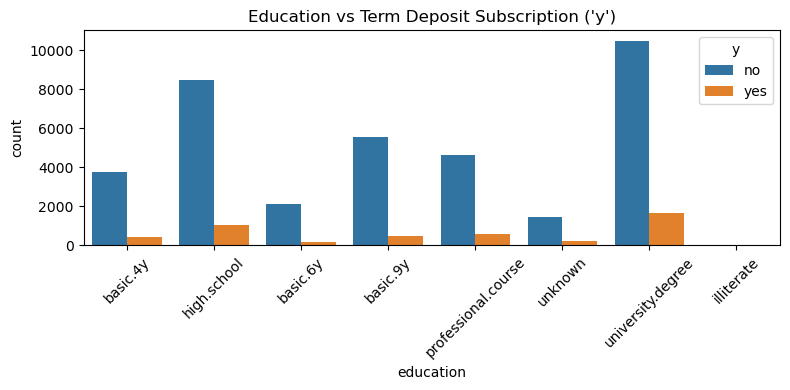

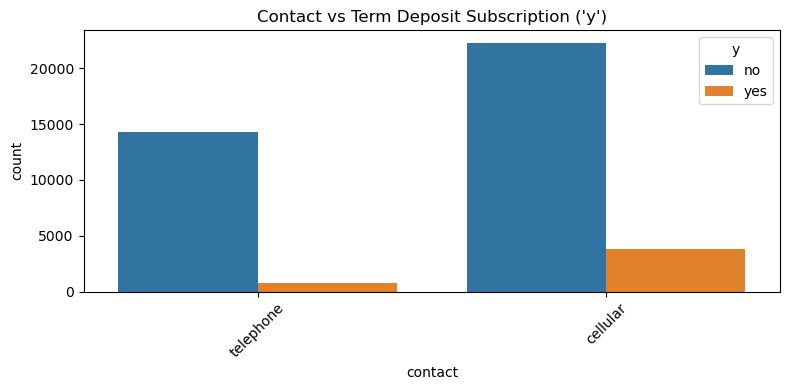

In [10]:
# Visualize categorical variables vs target
categorical_cols = ['job', 'education', 'contact']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f"{col.capitalize()} vs Term Deposit Subscription ('y')")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

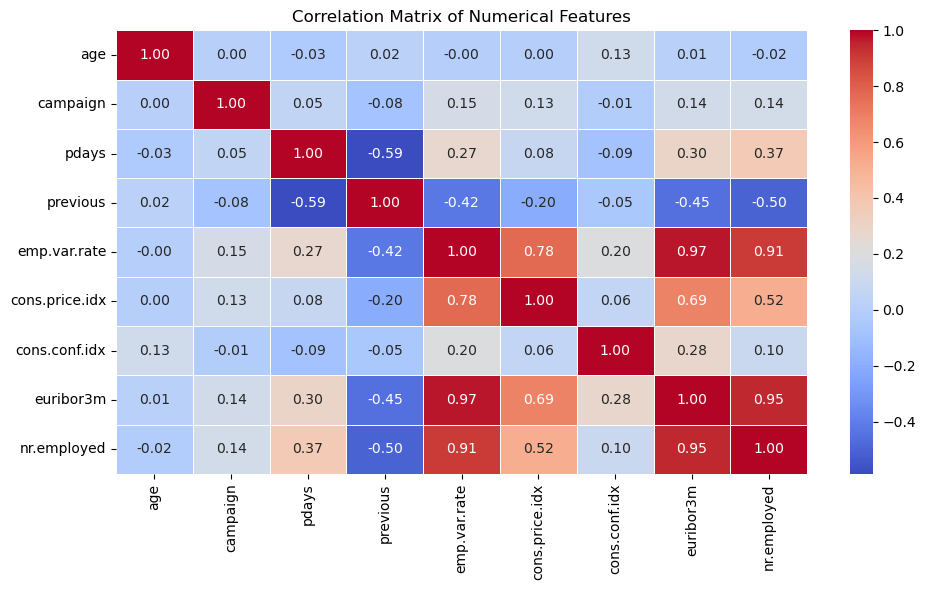

In [11]:
# Correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

### Data Preprocessing
Encode categorical variables and prepare dataset for modeling.

In [13]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)
# Encode target
df_encoded['y'] = df['y'].map({'no': 0, 'yes': 1})

### Split Dataset and Handle Imbalance
Apply SMOTE to balance classes in the training set.

In [15]:
# Split and apply SMOTE
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

### Model Training
Train a Random Forest Classifier on the balanced data.

In [17]:
# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

### Model Evaluation
Evaluate using confusion matrix, classification report, and ROC AUC.

In [19]:
# Evaluate the model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

[[7310    0]
 [   0  928]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7310
           1       1.00      1.00      1.00       928

    accuracy                           1.00      8238
   macro avg       1.00      1.00      1.00      8238
weighted avg       1.00      1.00      1.00      8238

ROC AUC Score: 1.0


### Feature Importance
Visualize top features influencing predictions.

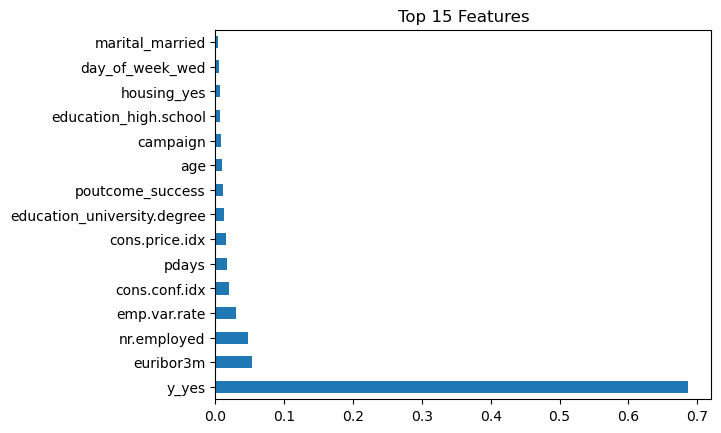

In [21]:
# Plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Features')
plt.show()

### Save Trained Model
Export the model for use in the Streamlit app.

In [23]:
# Save the trained model
joblib.dump(model, "term_deposit_model.pkl")

['term_deposit_model.pkl']